# Data Science Unit 2 Sprint Challenge 3

## Logistic Regression and Beyond

In this sprint challenge you will fit a logistic regression modeling the probability of an adult having an income above 50K. The dataset is available at UCI:

https://archive.ics.uci.edu/ml/datasets/adult

Your goal is to:

1. Load, validate, and clean/prepare the data.
2. Fit a logistic regression model
3. Answer questions based on the results (as well as a few extra questions about the other modules)

Don't let the perfect be the enemy of the good! Manage your time, and make sure to get to all parts. If you get stuck wrestling with the data, simplify it (if necessary, drop features or rows) so you're able to move on. If you have time at the end, you can go back and try to fix/improve.

### Hints

It has a variety of features - some are continuous, but many are categorical. You may find [pandas.get_dummies](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) (a method to one-hot encode) helpful!

The features have dramatically different ranges. You may find [sklearn.preprocessing.minmax_scale](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.minmax_scale.html#sklearn.preprocessing.minmax_scale) helpful!

## Part 1 - Load, validate, and prepare data

The data is available at: https://archive.ics.uci.edu/ml/datasets/adult

Load it, name the columns, and make sure that you've loaded the data successfully. Note that missing values for categorical variables can essentially be considered another category ("unknown"), and may not need to be dropped.

You should also prepare the data for logistic regression - one-hot encode categorical features as appropriate.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error, r2_score
pd.set_option('display.max_columns', None)  # Unlimited columns

In [2]:
column_names = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','y']
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',
                header=None, index_col=False, names=column_names)

# DF has the right number of celumns, but ~32k rows instead of the 
# ~49k rows that the description mentions. The others must be in
# the other files that I didn't use.
print(df.shape)
df.head()

(32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,y
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
# It took forever to figure out that the nan value is ' ?', with a
# space before the '?'.
df = df.replace(' ?', np.nan)

In [4]:
df.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
y                    0
dtype: int64

In [5]:
# Since the NaNs are all in categorical columns, I'm going to replace
# them with a new category so that they go into the regression like
# all the others.
df = df.fillna('unknown')
df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
y                 0
dtype: int64

In [6]:
# All the columns have the expected datatype.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education-num     32561 non-null int64
marital-status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital-gain      32561 non-null int64
capital-loss      32561 non-null int64
hours-per-week    32561 non-null int64
native-country    32561 non-null object
y                 32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


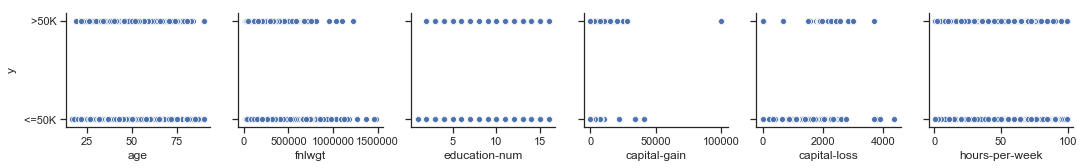

In [7]:
# Checking the distribution of the numerical variables
# Looks like they're pretty evenly distributed, though there's one
# severe outlier in capital-gain.  Shouldn't matter too much.
sns.set(style="ticks", color_codes=True)

# Plot y against the numerical columns
df_num_cols = df.select_dtypes('number').columns.tolist()
sns.pairplot(data=df, y_vars=['y'], x_vars=df_num_cols)
plt.show()

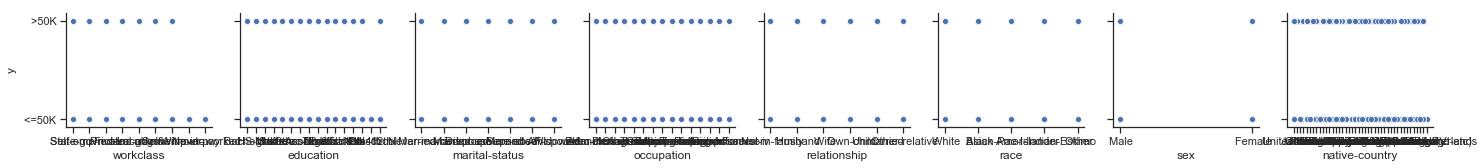

In [15]:
# I also checked the categorical columns, just in case.  As expected,
# though, no patterns are really visible here. 

sns.set(style="ticks", color_codes=True)
# Plot y against the categorical columns (except y itself.)
df_cat_cols = df.select_dtypes(exclude='number').columns.tolist()[:-1]
sns.pairplot(data=df, y_vars=['y'], x_vars=df_cat_cols)
plt.show()

In [9]:
### One-hot encoding

# Set y as the first column, and replace the labels with 0 and 1
# So that the one-hot-encoder won't think y is categorical
df2 = df[['y'] + df.columns.tolist()[:-1]]
df2.y = df2.y.replace({' <=50K':0, ' >50K':1})

# Encode the categorical columns only
df2 = pd.get_dummies(df2)
print(df2.shape)
df2.head()

(32561, 109)


,y,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,workclass_unknown,education_ 10th,education_ 11th,education_ 12th,education_ 1st-4th,education_ 5th-6th,education_ 7th-8th,education_ 9th,education_ Assoc-acdm,education_ Assoc-voc,education_ Bachelors,education_ Doctorate,education_ HS-grad,education_ Masters,education_ Preschool,education_ Prof-school,education_ Some-college,marital-status_ Divorced,marital-status_ Married-AF-spouse,marital-status_ Married-civ-spouse,marital-status_ Married-spouse-absent,marital-status_ Never-married,marital-status_ Separated,marital-status_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,occupation_unknown,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Female,sex_ Male,native-country_ Cambodia,native-country_ Canada,native-country_ China,native-country_ Columbia,native-country_ Cuba,native-country_ Dominican-Republic,native-country_ Ecuador,native-country_ El-Salvador,native-country_ England,native-country_ France,native-country_ Germany,native-country_ Greece,native-country_ Guatemala,native-country_ Haiti,native-country_ Holand-Netherlands,native-country_ Honduras,native-country_ Hong,native-country_ Hungary,native-country_ India,native-country_ Iran,native-country_ Ireland,native-country_ Italy,native-country_ Jamaica,native-country_ Japan,native-country_ Laos,native-country_ Mexico,native-country_ Nicaragua,native-country_ Outlying-US(Guam-USVI-etc),native-country_ Peru,native-country_ Philippines,native-country_ Poland,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,native-country_unknown
0,0,39,77516,13,2174,0,40,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,50,83311,13,0,0,13,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,38,215646,9,0,0,40,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,53,234721,7,0,0,40,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,28,338409,13,0,0,40,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Part 2 - Fit and present a Logistic Regression

Your data should now be in a state to fit a logistic regression. Use scikit-learn, define your `X` (independent variable) and `y`, and fit a model.

Then, present results - display coefficients in as interpretible a way as you can (hint - scaling the numeric features will help, as it will at least make coefficients more comparable to each other). If you find it helpful for interpretation, you can also generate predictions for cases (like our 5 year old rich kid on the Titanic) or make visualizations - but the goal is your exploration to be able to answer the question, not any particular plot (i.e. don't worry about polishing it).

It is *optional* to use `train_test_split` or validate your model more generally - that is not the core focus for this week. So, it is suggested you focus on fitting a model first, and if you have time at the end you can do further validation.

In [22]:
### Scaling the numerical variables

# I start a new DF
df3 = df2

# I get the list of numerical columns from an earlier DF,
# before I one-hot-encoded
num_cols = df.select_dtypes('number').columns.tolist()

# I scale the numerical columns in place and confirm results
df3[num_cols] = scale(df3[num_cols])
print(df3.shape)
df3.head()

(32561, 109)


,y,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,workclass_unknown,education_ 10th,education_ 11th,education_ 12th,education_ 1st-4th,education_ 5th-6th,education_ 7th-8th,education_ 9th,education_ Assoc-acdm,education_ Assoc-voc,education_ Bachelors,education_ Doctorate,education_ HS-grad,education_ Masters,education_ Preschool,education_ Prof-school,education_ Some-college,marital-status_ Divorced,marital-status_ Married-AF-spouse,marital-status_ Married-civ-spouse,marital-status_ Married-spouse-absent,marital-status_ Never-married,marital-status_ Separated,marital-status_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,occupation_unknown,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Female,sex_ Male,native-country_ Cambodia,native-country_ Canada,native-country_ China,native-country_ Columbia,native-country_ Cuba,native-country_ Dominican-Republic,native-country_ Ecuador,native-country_ El-Salvador,native-country_ England,native-country_ France,native-country_ Germany,native-country_ Greece,native-country_ Guatemala,native-country_ Haiti,native-country_ Holand-Netherlands,native-country_ Honduras,native-country_ Hong,native-country_ Hungary,native-country_ India,native-country_ Iran,native-country_ Ireland,native-country_ Italy,native-country_ Jamaica,native-country_ Japan,native-country_ Laos,native-country_ Mexico,native-country_ Nicaragua,native-country_ Outlying-US(Guam-USVI-etc),native-country_ Peru,native-country_ Philippines,native-country_ Poland,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,native-country_unknown
0,0,0.030671,-1.063611,1.134739,0.148453,-0.21666,-0.035429,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0.837109,-1.008707,1.134739,-0.145920,-0.21666,-2.222153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,-0.042642,0.245079,-0.420060,-0.145920,-0.21666,-0.035429,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,1.057047,0.425801,-1.197459,-0.145920,-0.21666,-0.035429,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,-0.775768,1.408176,1.134739,-0.145920,-0.21666,-0.035429,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [24]:
# Yup, numerical columns scaled as expected
df3.describe()

,y,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,workclass_unknown,education_ 10th,education_ 11th,education_ 12th,education_ 1st-4th,education_ 5th-6th,education_ 7th-8th,education_ 9th,education_ Assoc-acdm,education_ Assoc-voc,education_ Bachelors,education_ Doctorate,education_ HS-grad,education_ Masters,education_ Preschool,education_ Prof-school,education_ Some-college,marital-status_ Divorced,marital-status_ Married-AF-spouse,marital-status_ Married-civ-spouse,marital-status_ Married-spouse-absent,marital-status_ Never-married,marital-status_ Separated,marital-status_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,occupation_unknown,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Female,sex_ Male,native-country_ Cambodia,native-country_ Canada,native-country_ China,native-country_ Columbia,native-country_ Cuba,native-country_ Dominican-Republic,native-country_ Ecuador,native-country_ El-Salvador,native-country_ England,native-country_ France,native-country_ Germany,native-country_ Greece,native-country_ Guatemala,native-country_ Haiti,native-country_ Holand-Netherlands,native-country_ Honduras,native-country_ Hong,native-country_ Hungary,native-country_ India,native-country_ Iran,native-country_ Ireland,native-country_ Italy,native-country_ Jamaica,native-country_ Japan,native-country_ Laos,native-country_ Mexico,native-country_ Nicaragua,native-country_ Outlying-US(Guam-USVI-etc),native-country_ Peru,native-country_ Philippines,native-country_ Poland,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,native-country_unknown
count,32561.000000,3.256100e+04,3.256100e+04,3.256100e+04,3.256100e+04,3.256100e+04,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.0000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,0.240810,-1.617787e-16,-1.834062e-17,-1.241836e-16,-1.726862e-16,2.443626e-16,6.31

In [25]:
y = df3['y']
X = df3.drop(columns='y')

log_reg = LogisticRegression(multi_class='ovr',
                            solver='liblinear',
                            max_iter=500).fit(X, y)
# 'score' calculates the mean accuracy of the test, in this case
# evaluated on the same dataset where it was trained. Higher
# scores are better, and they're all in the unit interval.
log_reg.score(X, y)

0.8531064770737999

In [47]:
# In order to interpret the coefficients, I'll put them into a 
# new DF where I can keep track of their name, value, and absolute
# value
coefs_dict = {'name':df3.drop(columns='y').columns.tolist(),
              'coefficient':log_reg.coef_[0],
              'absolute': abs(log_reg.coef_[0])}

coefs = pd.DataFrame(coefs_dict)
coefs.head()

,name,coefficient,absolute
0,age,0.346623,0.346623
1,fnlwgt,0.074543,0.074543
2,education-num,0.755770,0.755770
3,capital-gain,2.308520,2.308520
4,capital-loss,0.259734,0.259734


In [49]:
# In order to find the most important coefficients, I'll sort
# them by absolute value and display the top 10. The largest
# absolute values correspond to the variables that have the 
# greatest impact on the predicted value of y.  In other words,
# the top 10 variables below have the greatest impact (positive
# or negative) on whether a person earns above 50K.

top_coefs = coefs.sort_values('absolute', ascending=False)
top_coefs.head(10)

,name,coefficient,absolute
3,capital-gain,2.308520,2.308520
46,occupation_ Priv-house-serv,-1.637413,1.637413
32,marital-status_ Married-AF-spouse,1.405858,1.405858
69,native-country_ Columbia,-1.288115,1.288115
33,marital-status_ Married-civ-spouse,1.257912,1.257912
35,marital-status_ Never-married,-1.209175,1.209175
28,education_ Preschool,-1.183005,1.183005
56,relationship_ Own-child,-1.156029,1.156029
64,sex_ Female,-1.130061,1.130061
66,native-country_ Cambodia,1.037444,1.037444


In [50]:
# Let's look at the top 10 variables that make it MORE likely a person
# will earn above 50k (i.e., the highest positive coefficients)

top_coefs_pos = coefs.sort_values('coefficient', ascending=False)
top_coefs_pos.head(10)

,name,coefficient,absolute
3,capital-gain,2.308520,2.308520
32,marital-status_ Married-AF-spouse,1.405858,1.405858
33,marital-status_ Married-civ-spouse,1.257912,1.257912
66,native-country_ Cambodia,1.037444,1.037444
58,relationship_ Wife,1.014315,1.014315
41,occupation_ Exec-managerial,0.861644,0.861644
87,native-country_ Italy,0.856981,0.856981
2,education-num,0.755770,0.755770
50,occupation_ Tech-support,0.726162,0.726162
48,occupation_ Protective-serv,0.645989,0.645989


In [51]:
# Let's look at the top 10 variables that make it LESS likely a person
# will earn above 50k (i.e., the highest negative coefficients)

top_coefs_neg = coefs.sort_values('coefficient', ascending=True)
top_coefs_neg.head(10)

,name,coefficient,absolute
46,occupation_ Priv-house-serv,-1.637413,1.637413
69,native-country_ Columbia,-1.288115,1.288115
35,marital-status_ Never-married,-1.209175,1.209175
28,education_ Preschool,-1.183005,1.183005
56,relationship_ Own-child,-1.156029,1.156029
64,sex_ Female,-1.130061,1.130061
13,workclass_ Without-pay,-1.010266,1.010266
71,native-country_ Dominican-Republic,-0.958436,0.958436
42,occupation_ Farming-fishing,-0.912868,0.912868
36,marital-status_ Separated,-0.841982,0.841982


In [ ]:
# Based on these coefficients, I'll create a couple of predictions 
# that tip the scales one way or another.

## Part 3 - Analysis, Interpretation, and Questions

### Based on your above model, answer the following questions

1. What are 3 features positively correlated with income above 50k?
2. What are 3 features negatively correlated with income above 50k?
3. Overall, how well does the model explain the data and what insights do you derive from it?

*These answers count* - that is, make sure to spend some time on them, connecting to your analysis above. There is no single right answer, but as long as you support your reasoning with evidence you are on the right track.

Note - scikit-learn logistic regression does *not* automatically perform a hypothesis test on coefficients. That is OK - if you scale the data they are more comparable in weight.

### Match the following situation descriptions with the model most appropriate to addressing them

In addition to logistic regression, a number of other approaches were covered this week. Pair them with the situations they are most appropriate for, and briefly explain why.

Situations:
1. You are given data on academic performance of primary school students, and asked to fit a model to help predict "at-risk" students who are likely to receive the bottom tier of grades.
2. You are studying tech companies and their patterns in releasing new products, and would like to be able to model and predict when a new product is likely to be launched.
3. You are working on modeling expected plant size and yield with a laboratory that is able to capture fantastically detailed physical data about plants, but only of a few dozen plants at a time.

Approaches:
1. Ridge Regression
2. Quantile Regression
3. Survival Analysis

## Answers to Part 3

### What are 3 features positively correlated with income above 50k?

Here are the top 10:

In [52]:
top_coefs_pos = coefs.sort_values('coefficient', ascending=False)
top_coefs_pos.head(10)

,name,coefficient,absolute
3,capital-gain,2.308520,2.308520
32,marital-status_ Married-AF-spouse,1.405858,1.405858
33,marital-status_ Married-civ-spouse,1.257912,1.257912
66,native-country_ Cambodia,1.037444,1.037444
58,relationship_ Wife,1.014315,1.014315
41,occupation_ Exec-managerial,0.861644,0.861644
87,native-country_ Italy,0.856981,0.856981
2,education-num,0.755770,0.755770
50,occupation_ Tech-support,0.726162,0.726162
48,occupation_ Protective-serv,0.645989,0.645989


### What are 3 features negatively correlated with income above 50k?
Here are the top 10:

In [54]:
top_coefs_neg = coefs.sort_values('coefficient', ascending=True)
top_coefs_neg.head(10)

,name,coefficient,absolute
46,occupation_ Priv-house-serv,-1.637413,1.637413
69,native-country_ Columbia,-1.288115,1.288115
35,marital-status_ Never-married,-1.209175,1.209175
28,education_ Preschool,-1.183005,1.183005
56,relationship_ Own-child,-1.156029,1.156029
64,sex_ Female,-1.130061,1.130061
13,workclass_ Without-pay,-1.010266,1.010266
71,native-country_ Dominican-Republic,-0.958436,0.958436
42,occupation_ Farming-fishing,-0.912868,0.912868
36,marital-status_ Separated,-0.841982,0.841982


### Overall, how well does the model explain the data and what insights do you derive from it?
The model had a mean accuracy of 0.85 (evaluated on the training dataset), which is pretty good. Also, the results reaffirm several well-known factors that relate to income, as well as some surprising ones.  Here are some notable insights that I get from these results:

### Variables correlated with wealth above 50k.

###### Obvious
* Capital gains
###### Well-known
* Three different variables related to being married
* Occupation: exucutive managerial
* Years of education
###### Surprising
* Occupation: tech support
* Occupation: protective services
* Countries: Italy and Cambodia

### Variables correlated with wealth under 50k.

###### Obvious
* the work class 'without pay'
###### Well-known
* Finished only preschool education
* Occupation: domestic servant
* Occupation: farmer/fisher
* Sex: Female
* Marital status: separated or never married
###### Confusing
* Relationship: "Own-child". (??)


## Answers to Part 4

### Match the following situation descriptions with the model most appropriate to addressing them

In addition to logistic regression, a number of other approaches were covered this week. Pair them with the situations they are most appropriate for, and briefly explain why.

Situations:
#### 1. 
You are given data on academic performance of primary school students, and asked to fit a model to help predict "at-risk" students who are likely to receive the bottom tier of grades.

**Quantile + Logistic Regression.** I know that this isn't one of the options, but I think that it works better than QR alone for the problem as stated. 

For a given combination of variables, Quantile Regression would provide us with a grade such that a certain proportion of students are above or below it. If you have a student with that combinaton of variables, however, you don't know where they fall in the set of y values that correspond to that X. You just know what percentage of students will fall in a particular quantile.

Now, imagine that we use QR to calculate the grade that corresponds to a particular cutoff (say, bottom 10%). We can then create two categories (above and below cutoff), and use LogR to predict the probability that a student will fall in one or the other given X. Thus, QR tells us where to put the threshold and LogR gives us a prediction for a particular student. 

#### 2. 
You are studying tech companies and their patterns in releasing new products, and would like to be able to model and predict when a new product is likely to be launched.

**Survival Analysis.** We always know when a tech company released their *last* product, and we're trying to pinpoint the moment when they'll release the next one.  These events correspond neatly to the birth and death events that SA is designed to deal with. The other factors that we analyze will help us predict the length of time between launches.

#### 3. 
You are working on modeling expected plant size and yield with a laboratory that is able to capture fantastically detailed physical data about plants, but only of a few dozen plants at a time.

**Ridge Regression.** RR shines in underconstrained problems, when we have a lot of variables but only a few datapoints.  We can measure a *lot* of phisical variables about plants, way more than the few dozen specimens at hand, so RR will help us deal with the extra dimensionality. PCA could also be used in this case.

